In [68]:
import pandas as pd
import numpy as np
import json
import os

In [69]:
from IPython.display import display, HTML

# For pandas dataframes - show all rows and columns
'''
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
'''

# For numpy arrays - show all elements
np.set_printoptions(threshold=np.inf)

# For pretty display of large HTML content
HTML("<style>.jp-OutputArea-output { max-height: none; }</style>")

In [70]:
folder_path = "./humaneval/python-small-test/"
json_files = [f for f in os.listdir(folder_path) if f.endswith(".json")]

all_entries = []

for file in json_files:
    file_path = os.path.join(folder_path, file)
    with open(file_path, "r") as f:
        content = json.load(f)
    for entry in content.get("data", []):
        entry["source_file"] = file
        all_entries.append(entry)

df = pd.DataFrame(all_entries)

# Step 2: Flatten `code_gpt_score` subfields
score_df = pd.json_normalize(df["code_gpt_score"])

# Step 3: Merge back to the original dataframe
df = df.drop(columns=["code_gpt_score"]).join(score_df)

# Optional: rename columns if needed
df = df.rename(columns={
    "code_gpt_score": "gpt_score",
    "comparison": "gpt_comparison",
    "parsed_comparison": "gpt_parsed_comparison"
})


df.head(2)


,pass,question,program,canonical_solution,question_id,source_file,gpt_score,gpt_comparison,gpt_parsed_comparison
0,True,"Task We are given two strings s and c, you hav...","def reverse_delete(s,c):\n\n # your code he...","def reverse_delete(s,c):\n s = ''.join([cha...",112,Qwen-2-0-1-0.4-sample-0.json,1.0,Step 1: Identify the required functionalities ...,Yes
1,True,You're given a list of deposit and withdrawal ...,from typing import List\n\n\ndef below_zero(op...,from typing import List\n\n\ndef below_zero(op...,3,Qwen-2-0-1-0.4-sample-0.json,0.0,### Evaluation\n\n1. **Required Functionalitie...,Yes


In [71]:
import re

def parse_filename(filename):
    """
    Parse a filename in the format 'Qwen-2-0-4-0.4-sample-0.json' to extract components.
    
    Args:
        filename (str): The filename to parse
        
    Returns:
        dict: Dictionary containing extracted components or None if pattern doesn't match
    """
    # Regular expression to match the pattern: Qwen-<step>-<analyze_prompt_index>-<compare_prompt_index>-<temperature>-sample-<number>.json
    pattern = r'Qwen-(\d+)-(\d+)-(\d+)-(\d+\.\d+)-sample-\d+\.json'
    
    match = re.match(pattern, filename)
    if match:
        return {
            'source_file': filename,
            'step': int(match.group(1)),
            'analyze_prompt_index': int(match.group(2)),
            'compare_prompt_index': int(match.group(3)),
            'temperature': float(match.group(4))
        }
    return None

def create_dataframe_from_filenames(file_list):
    """
    Create a DataFrame from a list of filenames by parsing each filename.
    
    Args:
        file_list (list): List of filenames to parse
        
    Returns:
        pandas.DataFrame: DataFrame containing the parsed information
    """
    results = []
    
    for filename in file_list:
        parsed_data = parse_filename(filename)
        if parsed_data:
            results.append(parsed_data)
    
    if not results:
        return pd.DataFrame(columns=['filename', 'step', 'analyze_prompt_index', 
                                    'compare_prompt_index', 'temperature'])
    
    return pd.DataFrame(results)

def process_directory(directory_path):
    """
    Process all matching files in a directory and return a DataFrame.
    
    Args:
        directory_path (str): Path to the directory containing the files
        
    Returns:
        pandas.DataFrame: DataFrame containing the parsed information
    """
    filenames = [f for f in os.listdir(directory_path) 
                if f.startswith('Qwen-') and f.endswith('.json')]
    return create_dataframe_from_filenames(filenames)

In [72]:
parsed_df = process_directory("./humaneval/python-small-test/")
df = pd.merge(
        df, 
        parsed_df, 
        on='source_file',
        how='inner'  # Only keep rows that match in both dataframes
    )
original = df.copy()
df = df[(df['gpt_parsed_comparison'] == 'Yes') | (df['gpt_parsed_comparison'] == 'No')]
#df = df[df['temperature'] == 0.4]
df.head(2)

,pass,question,program,canonical_solution,question_id,source_file,gpt_score,gpt_comparison,gpt_parsed_comparison,step,analyze_prompt_index,compare_prompt_index,temperature
0,True,"Task We are given two strings s and c, you hav...","def reverse_delete(s,c):\n\n # your code he...","def reverse_delete(s,c):\n s = ''.join([cha...",112,Qwen-2-0-1-0.4-sample-0.json,1.0,Step 1: Identify the required functionalities ...,Yes,2,0,1,0.4
1,True,You're given a list of deposit and withdrawal ...,from typing import List\n\n\ndef below_zero(op...,from typing import List\n\n\ndef below_zero(op...,3,Qwen-2-0-1-0.4-sample-0.json,0.0,### Evaluation\n\n1. **Required Functionalitie...,Yes,2,0,1,0.4


Metrics for each parameter combination:


,analyze_prompt_index,compare_prompt_index,temperature,accuracy,f1_score
1,0,1,0.4,0.871212,0.874074
2,0,2,0.4,0.832061,0.828125
0,0,0,0.4,0.761538,0.752000



Overall Metrics:
Accuracy: 0.8219
F1 Score: 0.8196


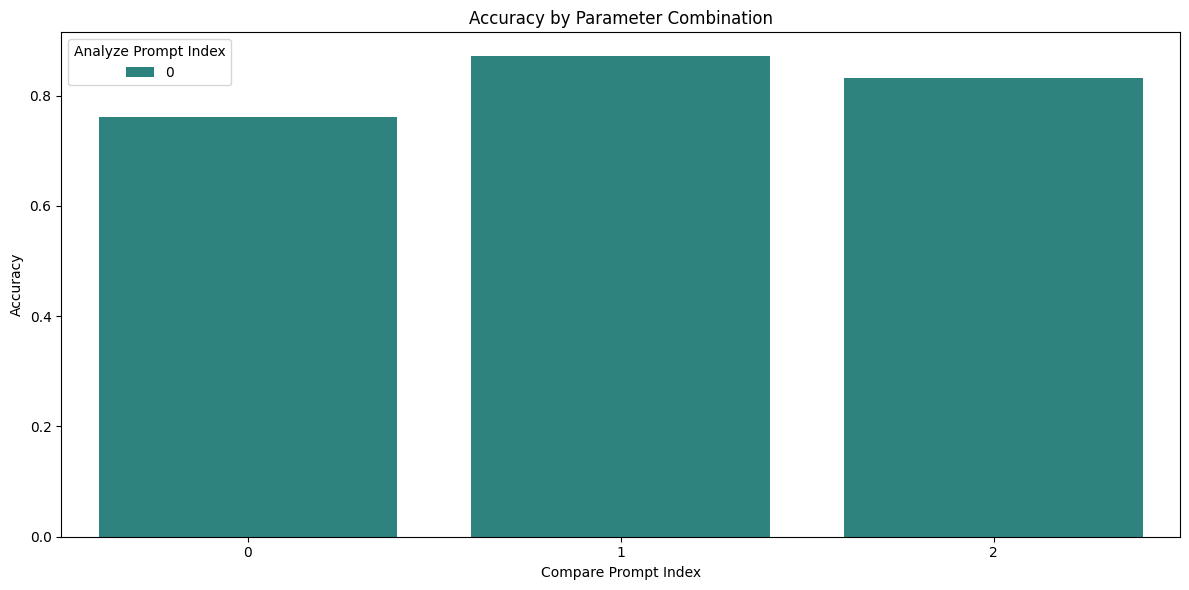

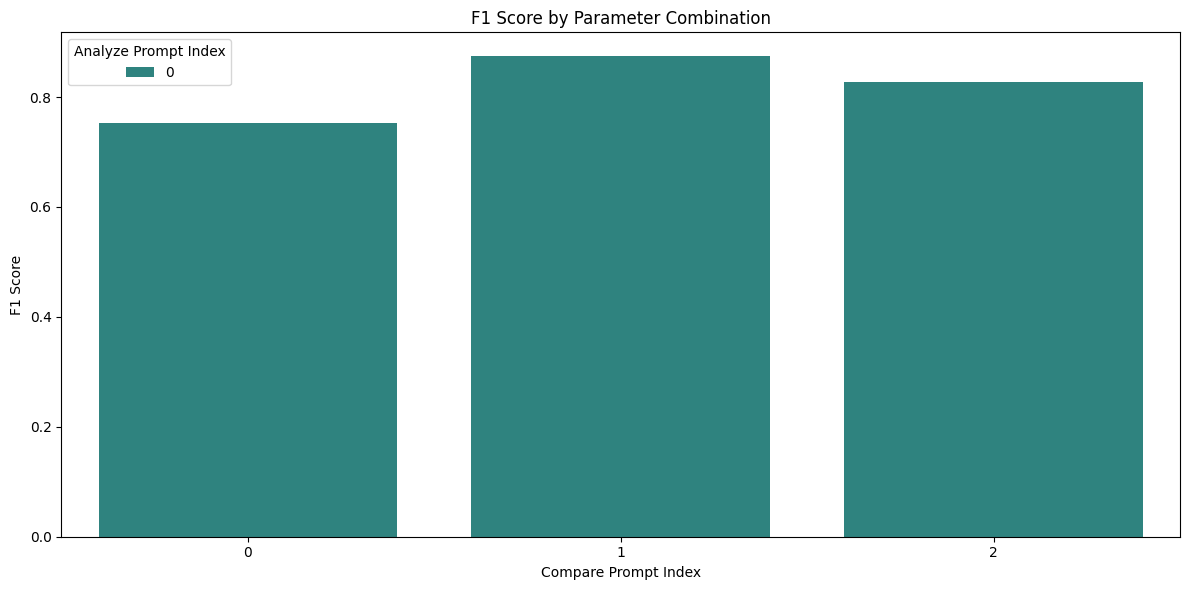

In [73]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Convert string 'Yes'/'No' to boolean True/False to match with 'pass'
df['predicted_bool'] = df['gpt_parsed_comparison'].apply(lambda x: True if x == 'Yes' else False)

# Group by the parameters we're interested in
grouped = df.groupby(['analyze_prompt_index', 'compare_prompt_index', 'temperature'])

# Create a dataframe to store the results
results = []

# Calculate metrics for each group
for name, group in grouped:
    analyze_idx, compare_idx, temp = name
    group_accuracy = accuracy_score(group['pass'], group['predicted_bool'])
    group_f1 = f1_score(group['pass'], group['predicted_bool'])
    group_conf_matrix = confusion_matrix(group['pass'], group['predicted_bool'])
    
    # Store the results
    results.append({
        'analyze_prompt_index': analyze_idx,
        'compare_prompt_index': compare_idx,
        'temperature': temp,
        'accuracy': group_accuracy,
        'f1_score': group_f1,
        'sample_size': len(group),
        'TN': group_conf_matrix[0, 0] if group_conf_matrix.shape == (2, 2) else 0,
        'FP': group_conf_matrix[0, 1] if group_conf_matrix.shape == (2, 2) else 0,
        'FN': group_conf_matrix[1, 0] if group_conf_matrix.shape == (2, 2) else 0,
        'TP': group_conf_matrix[1, 1] if group_conf_matrix.shape == (2, 2) else 0
    })

# Convert to DataFrame for easier visualization
results_df = pd.DataFrame(results)

# Sort by accuracy (descending)
results_df = results_df.sort_values('accuracy', ascending=False)

# Display the results
print("Metrics for each parameter combination:")
display(results_df[['analyze_prompt_index', 'compare_prompt_index', 'temperature', 'accuracy', 'f1_score']])

# Calculate overall metrics for comparison
overall_accuracy = accuracy_score(df['pass'], df['predicted_bool'])
overall_f1 = f1_score(df['pass'], df['predicted_bool'])
print(f"\nOverall Metrics:")
print(f"Accuracy: {overall_accuracy:.4f}")
print(f"F1 Score: {overall_f1:.4f}")

# Visualize accuracy by parameter combination
plt.figure(figsize=(12, 6))
sns.barplot(x='compare_prompt_index', y='accuracy', hue='analyze_prompt_index',
            palette='viridis', data=results_df)
plt.title('Accuracy by Parameter Combination')
plt.xlabel('Compare Prompt Index')
plt.ylabel('Accuracy')
plt.legend(title='Analyze Prompt Index')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Visualize F1 score by parameter combination
plt.figure(figsize=(12, 6))
sns.barplot(x='compare_prompt_index', y='f1_score', hue='analyze_prompt_index',
            palette='viridis', data=results_df)
plt.title('F1 Score by Parameter Combination')
plt.xlabel('Compare Prompt Index')
plt.ylabel('F1 Score')
plt.legend(title='Analyze Prompt Index')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [74]:
# Get the false negatives (actual pass = True, predicted = False)
false_negatives = df[(df['pass'] == True) & (df['predicted_bool'] == False)]
print(f"Total False Negatives: {len(false_negatives)}")

# Get the false positives (actual pass = False, predicted = True)
false_positives = df[(df['pass'] == False) & (df['predicted_bool'] == True)]
print(f"Total False Positives: {len(false_positives)}")

def sort_df(table):
    # Count occurrences of each question_id
    count = table['question_id'].value_counts()
    
    # Sort the table by frequency of question_id
    sorted_table = table.sort_values(by='question_id', key=lambda x: count[x], ascending=False)
    return sorted_table


false_negatives = sort_df(false_negatives)
false_positives = sort_df(false_positives)

Total False Negatives: 30
Total False Positives: 40


In [80]:
false_negatives = df[(df['gpt_parsed_comparison'] == 'No') & (df['pass'] == True) & (df['compare_prompt_index'] == 1)]
false_positives = df[(df['gpt_parsed_comparison'] == 'Yes') & (df['pass'] == False) & (df['compare_prompt_index'] == 1)]

In [99]:
false_positives.shape, false_negatives.shape

((13, 14), (4, 14))

In [84]:
num = -1

In [98]:
from IPython.display import display, HTML
import textwrap

# Set CSS to force wrapping and prevent any omission
display(HTML("""
<style>
    div.output_area pre {
        white-space: pre-wrap;       /* Preserve spacing but wrap */
        word-break: break-word;      /* Break long words if needed */
        overflow-wrap: anywhere;     /* Emergency break for very long strings */
    }
    div.output_area {
        max-width: 100%;            /* Prevent horizontal expansion */
        overflow-x: hidden !important;  /* Hide horizontal scroll */
    }
</style>
"""))



num += 1
test_df = false_positives
# Get the data (more efficient query)
#record = test_df[test_df['question_id'] == idx]
record = test_df.iloc[num]  # Assuming you want the first record for demonstration

# Display each part with guaranteed wrapping
def safe_display(title, content):
    display(HTML(f"<strong>{title}:</strong>"))
    display(HTML(f"<pre>{textwrap.dedent(str(content))}</pre>"))  # str() ensures no omission
    display(HTML("<hr style='margin: 10px 0;'>"))


safe_display('Question', record['question'])
safe_display("Program", record['program'])
safe_display("Canonical Solution", record['canonical_solution'])
safe_display("GPT Comparison", record['gpt_comparison'])
#safe_display('with/without analysis', record['analyze_prompt_index'])

display(HTML(f"<div>Case ID: {record['question_id']}, Index: {num}</div>"))


IndexError: single positional indexer is out-of-bounds

In [ ]:
# Create a copy of the original dataframe
new_df = original.copy()

# Add a new column that categorizes gpt_parsed_comparison values
def categorize_parsed_comparison(value):
    if value == 'Yes' or value == 'No':
        return True
    else:
        return False

# Apply the function to create a column indicating if the comparison was parsed
new_df['parsed_category'] = new_df['gpt_parsed_comparison'].apply(categorize_parsed_comparison)

result = []
# Group by prompt indices and temperature, then calculate the percentage of parsed responses
grouped_new = new_df.groupby(['analyze_prompt_index', 'compare_prompt_index', 'temperature'])
for name, group in grouped_new:
    total_count = len(group)
    parsed_count = group['parsed_category'].sum()
    parsed_percentage = (parsed_count / total_count) * 100 if total_count > 0 else 0
    result.append({
        'analyze_prompt_index': name[0],
        'compare_prompt_index': name[1],
        'temperature': name[2],
        'total_count': total_count,
        'parsed_count': parsed_count,
        'parsed_percentage': parsed_percentage
    })

grouped_new_result = pd.DataFrame(result)


# Sort by parsed_percentage in descending order
grouped_new_result = grouped_new_result.sort_values('parsed_percentage', ascending=False)

# Display the results
grouped_new_result

In [ ]:
dual_step_prompt = {
    "compare_prompt": [
        [
            {
                "role": "system",
                "content": """\
You will be provided with an algorithm contest problem. This problem will contain four parts: the problem statement, input description, output description, and several input-output pair examples.
Then, you will be provided with a code snippet that supposedly addresses the problem in Python.
Your task is to check if the code snippet covers the required functionalities. Only output the evaluation, do not provide a corrected version.
""",
            },
            {
                "role": "user",
                "content": """\
Problem Statement: \"\"\"
{{PROBLEM}}
\"\"\"
Code Snippet: \"\"\"python
{{CODE1}}
\"\"\"

There are also constraints on the input range  (e.g. 1 <= n <= 10^6), and programs running longer than 10 seconds will be treated as having timeout errors. Therefore, the correct code snippet needs to have both the correct logic and time complexity.
Read the code snippet carefully and analyze it. Check if the code snippet covers all the required functionalities of the problem.
"""
            },
            {
                "role": "assistant",
                "content": """\
Evaluation:
"""
            }
        ],
        [
            {
                "role": "system",
                "content": """\
You will be provided with an algorithm contest problem. This problem will contain four parts: the problem statement, input description, output description, and several input-output pair examples.
Then, you will be provided with a code snippet that supposedly addresses the problem in Python, and a reference answer.
Your task is to check if the code snippet covers the required functionalities. Only output the evaluation, do not provide a corrected version.
""",
            },
            {
                "role": "user",
                "content": """\
Problem Statement: \"\"\"
{{PROBLEM}}
\"\"\"
Reference Solution: \"\"\"{{LANGUAGE}}
{{CODE2}}
\"\"\"
Code Snippet: \"\"\"{{LANGUAGE}}
{{CODE1}}
\"\"\"

There are also constraints on the input range  (e.g. 1 <= n <= 10^6), and programs running longer than 10 seconds will be treated as having timeout errors. Therefore, the correct code snippet needs to have both the correct logic and appropriate time complexity. However, it's not necessary to compare the efficiency of the code snippet to the reference code.
Read the code snippet carefully and analyze it. Check if the code snippet covers all the required functionalities of the problem.
"""
            },
            {
                "role": "assistant",
                "content": """\
Evaluation:
"""
            }
        ],
        [
            {
                "role": "system",
                "content": """\
You will be provided with a problem statement and a code snippet that supposedly addresses the problem.
Your task is to check if the code snippet covers the required functionalities.
If the code snippet is correct, output your reason.
If the code snippet is incorrect, list the mistakes and explain the reasons.
""",
            },
            {
                "role": "user",
                "content": """\
Problem Statement: \"\"\"
{{PROBLEM}}
\"\"\"
Code Snippet: \"\"\"Python
{{CODE1}}
\"\"\"
"""
            },
            {
                "role": "assistant",
                "content": """\
Evaluation:
"""
            }
        ],
        [
            {
                "role": "system",
                "content": """\
You will be provided with a problem statement, a code snippet that supposedly addresses the problem, and a reference solution.
The reference solution is used to help you understand the problem, do not directly compare the code snippet to the reference code.
Your task is to check if the code snippet covers the required functionalities.
If the code snippet is correct, output your reason.
If the code snippet is incorrect, list the mistakes and explain the reasons.
""",
            },
            {
                "role": "user",
                "content": """\
Problem Statement: \"\"\"
{{PROBLEM}}
\"\"\"
Reference Solution: \"\"\"Python
{{CODE2}}
\"\"\"
Code Snippet: \"\"\"Python
{{CODE1}}
\"\"\"
"""
            },
            {
                "role": "assistant",
                "content": """\
Evaluation:
"""
            }
        ],
    ],
    "analyze_prompt": [
        [
            {
                "role": "system",
                "content": """\
You will be provided with an analysis result of a code snippet.
If the analysis believes that the code snippet is correct, output: "Yes". Otherwise, output: "No".
""",
            },
            {
                "role": "user",
                "content": """\
Analysis Result:\"\"\"
{{MISTAKES}}
\"\"\"
"""
            },
            {
                "role": "assistant",
                "content": """\
Final Answer (Yes or No):
"""
            }
        ],
    ],
}


In [ ]:
len(dual_step_prompt['compare_prompt'])  # Number of compare prompts

In [ ]:
# Instead of importing from an external location, let's use the dual_step_prompt variable
# that is already defined in cell 11

# The original problematic import:
# from mnt.task_runtime.shiyl_workspace.workspace.code-judge.codejudge_new,evaluation.humaneval.prompts import dual_step_prompt

# Since dual_step_prompt is already defined in cell 11, we don't need to import it again
# We can verify it exists by printing its structure

print(f"Number of compare prompts: {len(dual_step_prompt['compare_prompt'])}")
print(f"Number of analyze prompts: {len(dual_step_prompt['analyze_prompt'])}")